In [1]:
%pylab inline

# importing once and for all the needed stuff...
import gzip, os, sys, cPickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize as optimize
from scipy.stats import norm as Gaussian_PDF
from my_foos import Lin_Log_Bins, Smooth_Curve, p_n_pow_const, Power_Growth

from matplotlib import rc
#rc('font', family = 'serif', serif = 'Times')
#rc('text', usetex = True)
from matplotlib.ticker import NullFormatter

sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in",\
    "xtick.major.size": 10, "ytick.major.size": 10,\
    "xtick.minor.size": 5,  "ytick.minor.size": 5,})

# Colors and plot-related stuff...
colori = ['#F44E21', '#28CE9A', '#1A91E2', '#585959','#BF2D19', '#A3CD39', '#39D5F1',\
        '#7F5271',  '#FF9A15', '#068C7F', '#206584', '#8CBBEA']
markers = ('o', '8', '^', '<', 'D', '*', 's', 'p', 'v', 'h', 'H', '>', 'd')

cmap_winter = matplotlib.cm.winter
cmap_autumn = matplotlib.cm.autumn
cmap_summer = matplotlib.cm.summer
cmap_spring = matplotlib.cm.spring
cmap_rb = matplotlib.cm.rainbow

Populating the interactive namespace from numpy and matplotlib


## If you want to analyze the data, here you go...

In [2]:
if False: # "MPC"
    
    sys.path.append("/Users/ubi/ownCloud/PhD/TVN/Urne/py/tvnImporter/")
    from Network_Importer_Dev import Network_Importer
    
    baseDataDir = "/Users/ubi/ownCloud/PhD/TVN/strong_ties/data/twitter/twitter"
    d = "data-01-09_company_like"
    ODir = "/Users/ubi/ownCloud/PhD/TVN/Urne/out"
    for scheme in ["ak", "eak", "ek"]:
        tmp_Idirn = os.path.join(baseDataDir, d)
        tmp_Odirn = os.path.join(ODir, d)
        dat_file_name = Network_Importer(
    step_by_step=True, caller_idx=0, called_idx=1, clr_company_idx=2, cld_company_idx=3,
    starting_time=.0012, n_t_smpl=50, binning_scheme=scheme, act_bins_factor=1.25,
    deg_bins_factor=1.25, entr_bins_factor=1.5, zipped_f=False, IDir=tmp_Idirn, ODir=tmp_Odirn
        )
        print scheme
else:
    dat_file_name = '/home/ubi/owncloud/PhD/TVN/Urne/out/MPC/data/networkStats_a125_k125_e150_stBySt1_tScheve_bSchek.dat.gz'

## Loading data...

First define the datafile to use as *dat_file_name*...

In [3]:
DATA = cPickle.load(gzip.open(dat_file_name, 'rb'))

In [4]:
# Creating the needed dirs...
needed_dirs = ["P_akt", "kat", "pna", "chi_square"]
binningScheme = DATA["Params"]["binningScheme"]
#####################################

BASE_DIR = os.path.split(dat_file_name)[0]
for dirn in needed_dirs:
    tmp_path = os.path.join(BASE_DIR, dirn)
    if not (os.path.exists(tmp_path) and os.path.isdir(tmp_path)):
        os.mkdir(tmp_path)

## The $p(k)$ reinforcement process

In [5]:
DATA.keys()

['Stats', 'pkt', 'Arrays', 'TimeVecs', 'Params', 'pna', 'Bins']

In [6]:
def minDeg(DATA, nodeClass):
    tmpBin = DATA["Bins"]["Bins"]
    binningScheme = DATA["Params"]["binningScheme"]
    for i in range(binningScheme.index("k")):
        tmpBin = tmpBin["v"][nodeClass[i]]
    return tmpBin["b"][nodeClass[i+1]]

In [7]:
################################################
# Threshold: a point must have at least thres-events, thres new events and
# a difference between the two of at least thres to be accounted for...
Threshold = 5

# Minimum number of valid points for a curve to be fitted...
Nmin = 5

# Function that returns the mother class(es) to be used for a single pna plot
currentSuperClass = lambda classID: classID[:2]

# Factor smooting the curves...
smooth_factor = lambda v: (float(max(v))/max(1., min(v)))*.099

# Plotting settings...
print_legend = True
markers_size = 10
ax_fsize, lbl_fsize, lgnd_fsize = 16, 22, 10
figsize=(5,4)
################################################

In [8]:
# Here we save all the curves for the later fitting procedure and heat-map...
Pn_Curves = {}
pna = DATA['pna']

# We plot the p(n,a)
lastClass = None
some_plot = False
plotCount, classCount = 0, 0
for nodeClass, pni in sorted(pna.items()):
    print "\r", nodeClass, classCount+1, len(pna), "                        ",
    classCount += 1
    
    if lastClass != currentSuperClass(nodeClass):
        if some_plot:
            plt.xticks(size=ax_fsize)
            plt.yticks(size=ax_fsize)
            plt.xlabel(r"$k$", size=lbl_fsize)
            plt.ylabel(r"$p(k\to k+1)$", size=lbl_fsize)

            if print_legend:
                plt.legend(loc=1, fontsize=lgnd_fsize, ncol=1)
            plt.tight_layout()
            plt.savefig(os.path.join(BASE_DIR, "pna/%s_p_n_%s.pdf" % 
                        (binningScheme, "-".join("%d" % i for i in nodeClass))),
                        bbox_inches='tight')
            plt.close(fig_tmp)
        
        lastClass = currentSuperClass(nodeClass)
        some_plot = False
        plotCount = 0
        fig_tmp = plt.figure(figsize=figsize)        


    valid_degs = [k for k, evs in sorted(pni.items())\
                 if evs['s_new'] >= Threshold and evs['s_eve'] >= Threshold\
                 and (evs['s_eve'] - evs['s_new']) >= Threshold\
                 and float(k) <= minDeg(DATA, nodeClass)]

    X = np.array([float(k) for k in valid_degs])
    Y = np.array([float(pni[k]['s_new'])/float(pni[k]['s_eve']) for k in valid_degs])

    # Cleaning the zeroes...
    X = X[Y>.0]
    Y = Y[Y>.0]

    # Computing the uncertainity on the measured $p(k)$...
    STD_err = np.array([((Y[i]*(1.-Y[i]))/float(pni[k]['s_eve']))**.5\
                        for i,k in enumerate(valid_degs)])

    if len(X) > Nmin:
        some_plot = True
        X_plot, Y_plot = Smooth_Curve(X, Y, factor=smooth_factor(X))
        plt.loglog(X_plot,Y_plot, '--', marker=markers[plotCount%len(markers)], ms=markers_size,\
                   label=".".join("%d"%i for i in nodeClass), alpha=.9)

        Pn_Curves[nodeClass] = {'x': X, 'y': Y, 'w': STD_err, 'x_smooth': X_plot, 'y_smooth': Y_plot}
        plotCount += 1
        
if some_plot:
    plt.xticks(size=ax_fsize)
    plt.yticks(size=ax_fsize)
    plt.xlabel(r"$k$", size=lbl_fsize)
    plt.ylabel(r"$p(k\to k+1)$", size=lbl_fsize)

    if print_legend:
        plt.legend(loc=1, fontsize=lgnd_fsize, ncol=1)
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, "pna/%s_p_n_%s.pdf" %
                        (binningScheme, "-".join("%d" % i for i in nodeClass))),
                        bbox_inches='tight')
    plt.close(fig_tmp)

(6, 7) 42 716                         

/usr/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(51, 14) 716 716                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

In [9]:
################################################
# Select a single multi-activity, non fitted curves...

selectCriterion = lambda classID: classID[:2]
selectedMultiClasses = [(i,j,) for i in range(5, 30, 3) for j in range(2, 20, 3)]

some_plot = False
fig_tmp = plt.figure(figsize=figsize)
for nodeClass, pni in sorted(Pn_Curves.items()):
    if selectCriterion(nodeClass) not in selectedMultiClasses:
        continue
    some_plot = True

    X_plot, Y_plot = pni["x_smooth"], pni["y_smooth"]

    plt.loglog(X_plot,Y_plot, '--', ms=markers_size, alpha=.9,\
        marker=markers[(sum(nodeClass)*(nodeClass[0]+1))%len(markers)])

if some_plot:
    plt.xticks(size=ax_fsize)
    plt.yticks(size=ax_fsize)
    plt.xlabel(r"$k$", size=lbl_fsize)
    plt.ylabel(r"$p(k)$", size=lbl_fsize)

    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR,\
        "pna/%s_p_n_multiA_%s.pdf" %
        (binningScheme,
             "_".join(["-".join("%d"%c for c in cl) for cl in selectedMultiClasses])[:50])),
        bbox_inches='tight')

plt.close(fig_tmp)

## Now we compute the optimal $\beta$, then plotting the fitted $p(k\to k+1)$ with the total rescaled one...

In [10]:
################################################
# Beta interval to sweep...
Beta_int = np.arange(.0, 3.51, .01)

# Fixed beta overall or use the optimal beta for each bin...
Fixed_Beta = True

# setting bounds for c...
const_bounds = (1e-4, 1e+4)

# Plotting stuff...
Show_Legend = True
n_points_Pc = 8

################################################

In [11]:
Tot_Chi_Sums = np.zeros(len(Beta_int), dtype=float)
opt_pars = {b: {nc: [] for nc, _ in Pn_Curves.items()} for b in Beta_int}
Chi_Sums = {b: {nc: .0 for nc, _ in Pn_Curves.items()} for b in Beta_int}

for ii_ind, bb_val in enumerate(Beta_int):
    opt_params = np.array([bb_val, 2.])
    opt_bounds = [(bb_val*.9999, bb_val*1.0001), const_bounds]

    sum_chi_temp, sum_pop_temp, pts_pop_temp = .0, .0, .0
    for nodeClass, classDict in sorted(Pn_Curves.items()):
        nn = classDict['x']
        pn = classDict['y']
        wn = classDict['w']

        par_out, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(p_n_pow_const, x0 = opt_params,\
                args=(nn, pn, wn), bounds=opt_bounds, approx_grad=True,\
                maxfun=1000000, maxiter=1000000)

        sys.stdout.write("\rOptimization for bin a%s done with exit status %d: beta %.02f - cnst %.02f - chi2 %.02e"%\
            (".".join("%d" % c for c in nodeClass), dic_out['warnflag'], par_out[0], par_out[1], chi2_tmp))
        sys.stdout.flush()
        
        # Saving the summed chi square...
        sum_chi_temp += chi2_tmp
        sum_pop_temp += DATA['Bins']['N_A_K'][nodeClass]
        pts_pop_temp += float(len(nn) - 1)

        # Saving the constant and the chi_squared...
        opt_pars[bb_val][nodeClass] = [v for v in par_out]
        Chi_Sums[bb_val][nodeClass] = chi2_tmp

    if sum_pop_temp != .0:
        # We normalize by the number of fitted points, indeed this will be
        # the same number for every beta (we always fit the same curves!).
        Tot_Chi_Sums[ii_ind] = sum_chi_temp/pts_pop_temp

print "\n"

Ind_Bopt = np.argmin(Tot_Chi_Sums)
Beta_Opt = Beta_int[Ind_Bopt]
print 'beta_opt_act=%.02f' % Beta_Opt

Optimization for bin a51.12 done with exit status 0: beta 3.50 - cnst 10.44 - chi2 1.14e+023

beta_opt_act=1.70


In [12]:
# Select the aggregator of classes...
currentSuperClass = lambda classID: classID[:2]
selectedSuperClasses = [(i,j) for i in range(0, 380, 1) for j in range(0, 100, 1)]
toPlotSuperClasses = [(i,j) for i in range(3,300,3) for j in range(14, 110, 12)]

# x axis limit (set to None for free plot)
xlim = (1e4, 4e6)
ylim = (1e1, 1e3)

In [13]:
##################################################
# Now plotting the distribution of the optimized #
# constant for each activity class...            #
##################################################
n_points_Pc = 6

fig_Pconst = plt.figure()

# The containers for the cumulative (overall) distribution of P(c)...
TOT_cs = []
TOT_ns = []

firstPlot = True
for superClass in selectedSuperClasses:
    validClasses = [classId for classId in Pn_Curves.keys() if currentSuperClass(classId) == superClass]
    if not validClasses: continue
        
    constVals, popVals = [], []
    for nodeClass in validClasses:
        optBetaValue = Beta_Opt if Fixed_Beta else np.argmin([Chi_Sums[b][nodeClass] for b in Beta_int])
        constVals.append(opt_pars[optBetaValue][nodeClass][1])
        popVals.append(DATA["Bins"]["N_A_K"][nodeClass])
        
        TOT_cs.append(opt_pars[optBetaValue][nodeClass][1])
        TOT_ns.append(DATA["Bins"]["N_A_K"][nodeClass])
    constVals, popVals = np.array(constVals), np.array(popVals)
    if len(np.unique(constVals)) <= 1: continue
        
    Y, X = np.histogram(constVals, weights=popVals, density=True, bins=\
        np.logspace(np.log10(max(const_bounds[0], constVals.min())),\
                    np.log10(min(const_bounds[1], constVals.max())), n_points_Pc))
    X = (X[1:] + X[:-1])/2.
    X = X[Y>.0]
    Y = Y[Y>.0]
    if superClass in toPlotSuperClasses:
        plt.loglog(X, Y,'--', alpha=.8,\
               marker=markers[selectedSuperClasses.index(superClass)%len(markers)],\
               label=r"$t_e=$"*firstPlot + r"$%.01e$" % DATA["Bins"]["Bins"]["b"][superClass[0]])# * firstPlot +  ".".join("%d"%c for c in superClass))
               # label=r"$t_e=$" * firstPlot +  ".".join("%d"%c for c in superClass[:1]))
        if firstPlot: firstPlot = False
    
# Then plotting the overall distribution...
YY, XX = np.histogram(TOT_cs, weights=TOT_ns, density=True, bins=\
    np.logspace(np.log10(max(const_bounds[0],min(TOT_cs))), np.log10(min(const_bounds[1],max(TOT_cs))), n_points_Pc))
XX = (XX[1:] + XX[:-1])/2.
XX = XX[YY>.0]
YY = YY[YY>.0]
plt.loglog(XX, YY, '-', lw=4, color='#068C7F', label='All')    


if Show_Legend:
    plt.legend(loc=3, fontsize=lgnd_fsize+5, ncol=3,
               handlelength=.5, borderpad =.2, labelspacing=.2, columnspacing=.5)
    
plt.xticks(size=ax_fsize)
plt.yticks(size=ax_fsize)
plt.xlabel(r"$c_i$", size=lbl_fsize)
plt.ylabel(r"$P(c_i)$", size=lbl_fsize)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'chi_square/%s_P_c.pdf' % binningScheme), bbox_inches='tight')
plt.close(fig_Pconst)

In [14]:
print "done"

done


In [15]:
##################################################
# Now plotting the fitted p(n) for each activity #
# class and the total rescaled plot...           #
##################################################

# Selected activity classes for the overall rescaled p(k) function...
Sel_acts = range(20,390,12)
singlePlotEvery = 1000

########################################################

fig_pn_tot = plt.figure(1, figsize=figsize)
resc_lim = [1000, .01]

ak = 0
for class_tuple, class_dict in sorted(Pn_Curves.items()):
    tmp_pars = opt_pars[Beta_Opt][class_tuple]
    XX = np.logspace(.0, np.log10(max(class_dict['x'])), 50)
    
    if ak % singlePlotEvery == 0:
        fig_tmp = plt.figure(2, figsize=figsize)
        fig_tmp = plt.figure(2)
        serie_tmp = plt.loglog(class_dict['x_smooth'], class_dict['y_smooth'],\
                   linestyle='', marker=markers[ak%len(markers)], ms=markers_size, alpha=.9)
        
        plt.loglog(XX, p_n_pow_const(tmp_pars, XX), '-', lw=2, alpha=.75, color=serie_tmp[0].get_c())
        
        plt.figure(2)
        plt.tight_layout()
        plt.savefig(os.path.join(BASE_DIR, 'pna/%s_p_n_fit_%s.pdf' %
            (binningScheme, "-".join(["%r"%v for v in class_tuple]))),
            bbox_inches='tight')
        plt.close(fig_tmp)

    if ak in Sel_acts:
        plt.figure(1)
        XX = class_dict['x_smooth']/tmp_pars[1]
        YY = class_dict['y_smooth']**(1./tmp_pars[0])
        plt.loglog(XX, YY, marker=markers[ak%len(markers)], ms=markers_size, alpha=.9)
        if max(XX) > resc_lim[1]: resc_lim[1] = max(XX)
        if min(XX) < resc_lim[0]: resc_lim[0] = min(XX)

    ak += 1

# for ak, act_dic in sorted(Pn_Curves.items()):
#     fig_tmp = plt.figure(2, figsize=figsize)
#     for dk, pni in sorted(act_dic.items()):
#         if dk in []:
#             continue
#         fig_tmp = plt.figure(2)
#         serie_tmp = plt.loglog(pni['x_smooth'], pni['y_smooth'],\
#                    linestyle='', marker=markers[dk%len(markers)], ms=markers_size, alpha=.9)
#         
#         XX = np.logspace(.0, np.log10(max(pni['x'])), 50)
#         plt.loglog(XX, p_n_pow_const(opt_pars[Optimal_Beta_bin[ak][dk]['beta']][ak][dk], XX),\
#                    '-', lw=2, alpha=.75, color=serie_tmp[0].get_c())
#         
#         if ak in Sel_acts:
#             plt.figure(1)
#             XX = pni['x_smooth']/opt_pars[Optimal_Beta_bin[ak][dk]['beta']][ak][dk][1]
#             YY = pni['y_smooth']**(1./opt_pars[Optimal_Beta_bin[ak][dk]['beta']][ak][dk][0])
#             plt.loglog(XX, YY, marker=markers[(ak*(dk+1))%len(markers)], ms=markers_size, alpha=.9)
#             if max(XX) > resc_lim[1]: resc_lim[1] = max(XX)
#             if min(XX) < resc_lim[0]: resc_lim[0] = min(XX)
#             
#     plt.figure(2)
#     plt.tight_layout()
#     plt.savefig(os.path.join(BASE_DIR, 'pna/p_n_fit_%02d.pdf' % ak), bbox_inches='tight')
#     plt.close(fig_tmp)

plt.figure(1)
XXX = np.logspace(np.floor(np.log10(resc_lim[0])), np.ceil(np.log10(resc_lim[1])), 100)
plt.loglog(XXX, 1./(1. + XXX), '-k', lw=4, alpha=.85, label=r"$(1+x)^{-1}$")

plt.xticks(size=ax_fsize)
plt.yticks(size=ax_fsize)
plt.xlabel(r"$x=k/c_i$", size=lbl_fsize)
plt.ylabel(r"$p(x)^{1/\beta}$", size=lbl_fsize)

plt.legend(loc=3, fontsize=lbl_fsize, ncol=1)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'pna/%s_all_p_n.pdf' % binningScheme), bbox_inches='tight')
plt.close(fig_pn_tot)

In [16]:
##################################################
# Now plotting the fitted p(n) for each activity #
# class and the total rescaled plot...           #
##################################################

# Selected activity classes for the overall rescaled p(k) function...
Sel_acts = range(90, 170, 10)
singlePlotEvery = 100

########################################################

fig_pn_tot = plt.figure(1, figsize=figsize)
resc_lim = [1000, .01]

ak = 0
for class_tuple, class_dict in sorted(Pn_Curves.items()):
    if ak % singlePlotEvery == 0:
        fig_tmp = plt.figure(2, figsize=figsize)

        fig_tmp = plt.figure(2)
        serie_tmp = plt.loglog(class_dict['x_smooth'], class_dict['y_smooth'],\
                   linestyle='', marker=markers[ak%len(markers)], ms=markers_size, alpha=.9)

        tmp_pars = opt_pars[Beta_Opt][class_tuple]
        XX = np.logspace(.0, np.log10(max(class_dict['x'])), 50)
        plt.loglog(XX, p_n_pow_const(tmp_pars, XX), '-', lw=2, alpha=.75, color=serie_tmp[0].get_c())
        
        plt.figure(2)
        plt.tight_layout()
        plt.savefig(os.path.join(BASE_DIR, 'pna/%s_p_n_fit_%s.pdf' %
            (binningScheme, "-".join(["%r"%v for v in class_tuple]))),
            bbox_inches='tight')
        plt.close(fig_tmp)

    if ak in Sel_acts:
        plt.figure(1)
        XX = class_dict['x_smooth']/tmp_pars[1]
        YY = class_dict['y_smooth']**(1./tmp_pars[0])
        plt.loglog(XX, YY, marker=markers[ak%len(markers)], ms=markers_size, alpha=.9)
        if max(XX) > resc_lim[1]: resc_lim[1] = max(XX)
        if min(XX) < resc_lim[0]: resc_lim[0] = min(XX)

    ak += 1

# for ak, act_dic in sorted(Pn_Curves.items()):
#     fig_tmp = plt.figure(2, figsize=figsize)
#     for dk, pni in sorted(act_dic.items()):
#         if dk in []:
#             continue
#         fig_tmp = plt.figure(2)
#         serie_tmp = plt.loglog(pni['x_smooth'], pni['y_smooth'],\
#                    linestyle='', marker=markers[dk%len(markers)], ms=markers_size, alpha=.9)
#         
#         XX = np.logspace(.0, np.log10(max(pni['x'])), 50)
#         plt.loglog(XX, p_n_pow_const(opt_pars[Optimal_Beta_bin[ak][dk]['beta']][ak][dk], XX),\
#                    '-', lw=2, alpha=.75, color=serie_tmp[0].get_c())
#         
#         if ak in Sel_acts:
#             plt.figure(1)
#             XX = pni['x_smooth']/opt_pars[Optimal_Beta_bin[ak][dk]['beta']][ak][dk][1]
#             YY = pni['y_smooth']**(1./opt_pars[Optimal_Beta_bin[ak][dk]['beta']][ak][dk][0])
#             plt.loglog(XX, YY, marker=markers[(ak*(dk+1))%len(markers)], ms=markers_size, alpha=.9)
#             if max(XX) > resc_lim[1]: resc_lim[1] = max(XX)
#             if min(XX) < resc_lim[0]: resc_lim[0] = min(XX)
#             
#     plt.figure(2)
#     plt.tight_layout()
#     plt.savefig(os.path.join(BASE_DIR, 'pna/p_n_fit_%02d.pdf' % ak), bbox_inches='tight')
#     plt.close(fig_tmp)

plt.figure(1)
XXX = np.logspace(np.floor(np.log10(resc_lim[0])), np.ceil(np.log10(resc_lim[1])), 100)
plt.loglog(XXX, 1./(1. + XXX), '-k', lw=4, alpha=.85, label=r"$(1+x)^{-1}$")

plt.xticks(size=ax_fsize)
plt.yticks(size=ax_fsize)
plt.xlabel(r"$x=k/c_i$", size=lbl_fsize)
plt.ylabel(r"$p(x)^{1/\beta}$", size=lbl_fsize)

plt.legend(loc=3, fontsize=lbl_fsize, ncol=1)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'pna/%s_all_p_n.pdf' % binningScheme), bbox_inches='tight')
plt.close(fig_pn_tot)

In [17]:
# ##################################################
# # Now plotting the fitted p(n) for a selected    #
# # activity class with single beta for each bin.  #
# ##################################################
# 
# # Selected activity classes for the overall rescaled p(k) function...
# Sel_act = 26
# Discarded_ks = []
# 
# ########################################################
# 
# fig_pn_tot = plt.figure(1, figsize=figsize)
# fig_tmp = plt.figure(2, figsize=figsize)
# act_dic = Pn_Curves[Sel_act]
# FirstPlot = True
# for dk, pni in sorted(act_dic.items()):
#     print dk
#     if dk in Discarded_ks:
#         continue
#         
#     label = r"$\beta = " if FirstPlot else r"  $"
#     if FirstPlot: FirstPlot = False
#     label += r"%.01f$" % Optimal_Beta_bin[Sel_act][dk]['beta']
#     
#     serie_tmp = plt.loglog(pni['x_smooth'], pni['y_smooth'],\
#                linestyle='', marker=markers[dk%len(markers)], ms=markers_size, alpha=.9, label=label)
# 
#     
#     XX = np.logspace(.0, np.log10(max(pni['x'])), 50)
#     
#     
#     plt.loglog(XX, p_n_pow_const(opt_pars[Optimal_Beta_bin[Sel_act][dk]['beta']][Sel_act][dk], XX),\
#                '-', lw=2, alpha=.75, color=serie_tmp[0].get_c())
# 
# plt.xticks(size=ax_fsize)
# plt.yticks(size=ax_fsize)
# plt.xlabel(r"$k$", size=lbl_fsize)
# plt.ylabel(r"$p(k)$", size=lbl_fsize)
# 
# frame = plt.legend(loc=3, fontsize=(lbl_fsize*4/5), ncol=4, handlelength=.25, numpoints=1,\
#           columnspacing=.5, handletextpad=.7, framealpha=1., frameon=True)
# frame = frame.get_frame()
# frame.set_color('white')
# frame.set_facecolor('white')
# frame.set_edgecolor('white')
# 
# plt.tight_layout()
# plt.savefig(os.path.join(BASE_DIR, 'pna/%s_p_n_fit_bs_%02d.pdf'%
#                 (binningScheme,Sel_act)), bbox_inches='tight')
# plt.close()

# Save all that matters or load the data to skip the previous part

In [18]:
BASE_DIR

'/home/ubi/owncloud/PhD/TVN/Urne/out/MPC/data'

In [19]:
reloadData = False

import cPickle
if reloadData:
    with open(os.path.join(BASE_DIR, "pn_data_out_bSch%s.pkl" % binningScheme), "rb") as f:
        dataDump = cPickle.load(f)
        Chi_Sums = dataDump["Chi_Sums"]
        Tot_Chi_Sums = dataDump['Tot_Chi_Sums']
        opt_pars = dataDump["opt_pars"]    
        opt_params = dataDump["opt_params"]
        Fixed_Beta = dataDump["Fixed_Beta"]  
        Beta_int = dataDump["Beta_int"]
        Beta_Opt = dataDump["Beta_Opt"]    
        Ind_Bopt = dataDump["Ind_Bopt"]    
        BASE_DIR = dataDump["BASE_DIR"]    
        binningScheme = dataDump["binningScheme"]
        Pn_Curves = dataDump["Pn_Curves"]
else:
    with open(os.path.join(BASE_DIR, "pn_data_out_bSch%s.pkl" % binningScheme), "wb") as f:
        dataDump = {
            "Chi_Sums": Chi_Sums,
            'Tot_Chi_Sums': Tot_Chi_Sums,
            "opt_pars": opt_pars,
            "opt_params": opt_params,
            "Fixed_Beta": Fixed_Beta,
            "Beta_int": Beta_int,
            "Beta_Opt": Beta_Opt,
            "Ind_Bopt": Ind_Bopt,
            "BASE_DIR": BASE_DIR,
            "binningScheme": binningScheme,
            "Pn_Curves": Pn_Curves,
        }
        cPickle.dump(dataDump, f)

## ... and now the heatmap with bands...

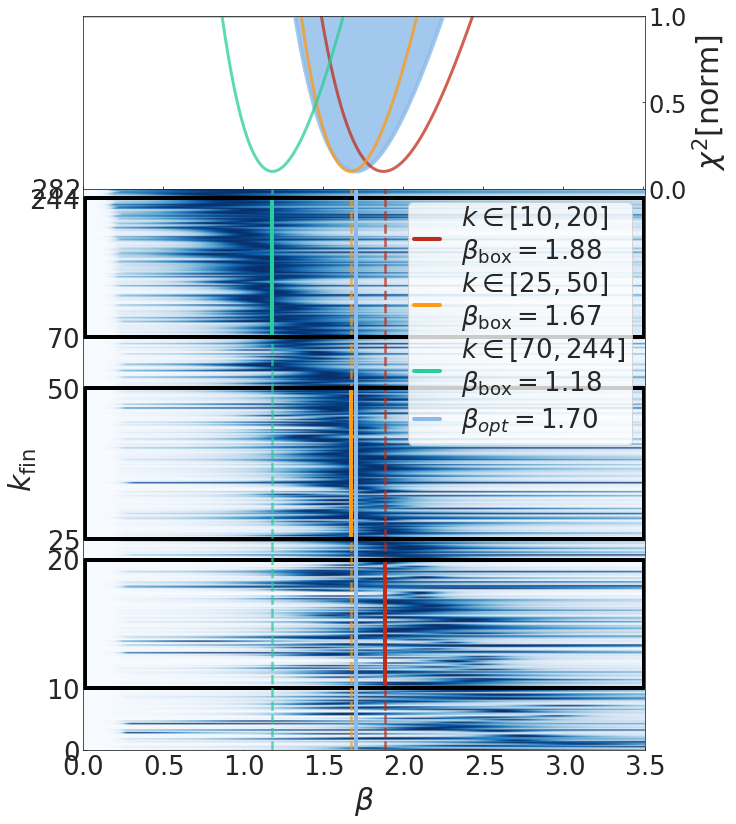

In [20]:
######################################
# The boxes to show the various betas...
#Boxes_lim = [[10,20], [40,80]] # PRA
#Boxes_lim = [[10,20], [25,50], [70, 300]] # PRB
#Boxes_lim = [[10,20], [20, 50]] # PRD
#Boxes_lim = [[7,15], [15,60]] # PRE
#Boxes_lim = [[10,20], [20,150]] # PRL
#Boxes_lim = [[10,25], [30,60], [80, 400]] # TWT
#Boxes_lim = [[10,20], [30,60], [90, 294]] # MPN
Boxes_lim = [[10,20], [25,50], [70, 244]] # APS entrance

# Whether or not to plot a guide to the eye...
Plot_Diag = False
diag_beta = [2.4, 1.2]
diag_degs = [0, 293]

# The program will rescale the curves between ValMin and ValMax so
# as to compare them...
ValMax = 1.
ValMin = .1

######################################
#Plot stuff (here we have a little more things ;) )
###################################### You should not touch the stuff here :)
left, bottom, width, height = .1, .1, .65, .65 # The rectangulum position and size for the HM
bottom_h = bottom + height
rect_HM = [left, bottom, width, height]
rect_X2 = [left, bottom_h, width, .2]

fig_tot = plt.figure(1, figsize=(12,12))
axX2 = plt.axes(rect_X2)
axX2.xaxis.set_major_formatter(NullFormatter())
axHM = plt.axes(rect_HM)

CMPS = ['Oranges', 'Reds', 'Greens']
Colors = ['#BF2D19', '#FF9A15', '#28CE9A']
Color_Tot = '#8CBBEA'
###################################### End of plot stuff...

Map_Original = np.zeros((len(Pn_Curves), len(Beta_int)), dtype=float)
Kmins = np.zeros(Map_Original.shape[0], dtype=float)
row = 0
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm, Normalize
for class_tuple, class_values in Chi_Sums[Beta_int[0]].items():
    Map_Original[row] = np.array([Chi_Sums[bb][class_tuple] for bb in Beta_int])
    Kmins[row] = minDeg(DATA, class_tuple)
    row += 1
    
ISkmin = np.argsort(Kmins)
Map_Original = Map_Original[ISkmin][:]
Kmins = Kmins[ISkmin]

DeltaVal = ValMax - ValMin

if False:
    # Now rescale the map so that the curves are comparable...
    # Lower the minimum to zero for all the rows...
    Map_Rescaled = Map_Original - np.array([[min_row]*Map_Original.shape[1] for min_row in Map_Original.min(axis=1)])
    # Set 1. as a reference in the far right of the map for each row...
    Map_Rescaled /= np.array([[row[-5] if row[-5]>row_val else 1. for row_val in row] for row in Map_Rescaled])
    # Rescale and shift...
    Map_Rescaled *= DeltaVal
    Map_Rescaled += ValMin
    Map_Rescaled = -np.log10(Map_Rescaled)
else:
    Map_Rescaled = Map_Original / np.array([[min_row]*Map_Original.shape[1] for min_row in Map_Original.min(axis=1)])
    Map_Rescaled **= -1.
    

#figHM = axHM.pcolormesh(Map_Rescaled, cmap='Blues', norm=Normalize(), edgecolors='none', shading='gouraud')
figHM = axHM.pcolormesh(Map_Rescaled, cmap='Blues', norm=Normalize(), edgecolors='none', shading='gouraud')

#axHM.plot([300, 120], [0, len(Kmins)], '--', lw=5, alpha=.9, color='#FCDD2B')

#plt.colorbar(figHM)

tot_chi2_curve = Tot_Chi_Sums/Tot_Chi_Sums.min()/1.1
tot_chi2_curve -= min(tot_chi2_curve) - .1
axX2.fill_between(np.arange(len(Beta_int)), tot_chi2_curve, 1.,\
                color=Color_Tot, lw=4, alpha=.8, edgecolor='#4167af')

y_labels = [(0,0), (len(Kmins)-1, Kmins[-1])]
for boxi, box_edges in enumerate(Boxes_lim):
    if box_edges[0] < Kmins[0] or box_edges[1] > Kmins[-1]:
        print "Ignoring box ", box_edges, " because it is out of bound: kmin = %d, kmax = %d" % (Kmins[0], Kmins[-1])
        continue
    tmp_chi2_curve = Map_Original[(Kmins>=box_edges[0]) & (Kmins<=box_edges[1])].sum(axis=0)
    tmp_chi2_curve /= tmp_chi2_curve.min()*1.1
    tmp_chi2_curve -= tmp_chi2_curve.min() - .1
    axX2.plot(np.arange(len(Beta_int)), tmp_chi2_curve,\
                     color=Colors[boxi], lw=3, alpha=.75)
    
    
    # The reference curve and the black box...
    box_bot = np.argmax(Kmins>=box_edges[0])
    box_top = np.argmin(Kmins<=box_edges[1])
    min_ind = np.argmin(tmp_chi2_curve)
    axHM.plot([min_ind]*2, [0, Map_Original.shape[0]-1], '--',\
              color=Colors[boxi], lw=2.5, alpha=.75)
    axHM.plot([min_ind]*2, [box_bot, box_top], '-', color=Colors[boxi],\
              lw=4, label=r'$k\in[%d, %d]$' '\n' r'$\beta_{\rm box}=%.02f$'%\
             (box_edges[0], box_edges[1], Beta_int[min_ind]))
    axHM.plot([1.,1.,len(Beta_int)-1.5, len(Beta_int)-1.5, 1.],\
        [box_bot, box_top, box_top, box_bot, box_bot], '-k', lw=4)
    
    y_labels.extend([(box_bot, box_edges[0]), (box_top, box_edges[1])])

if Plot_Diag:
    axHM.plot([np.argmax(Beta_int >= b) for b in diag_beta], [np.argmax(Kmins >= k) for k in diag_degs],\
              '--', lw=5, alpha=.9, color='#FCDD2B')
    
beta_labels = range(0, len(Beta_int), 50)
axHM.xaxis.set_ticks(beta_labels, minor=True)
axHM.xaxis.set_ticklabels([r"$%.01f$"%Beta_int[i] for i in beta_labels], size=26)
#axHM.xaxis.set_tick_params(which='both', direction='in', length=12, width=10, zorder=0)

axHM.set_yticks([ylab[0] for ylab in y_labels])
axHM.set_yticklabels([r"$%d$"%ylab[1] for ylab in y_labels], size=26)
    
axHM.plot([Ind_Bopt]*2, [0, len(Kmins)-1],\
        '-', color=Color_Tot, lw=4,\
        label=r'$\beta_{opt} = %.02f$' % (Beta_Opt))



axX2.set_ylim(0,1)
axX2.set_xlim(0,len(Beta_int))
#axHM.legend(fontsize=26, loc=3, bbox_to_anchor=(.00125,.00125), frameon=True, borderpad=.25, labelspacing=.25, handlelength=1.)
axHM.legend(fontsize=26, loc=1, frameon=True, borderpad=.25, labelspacing=.25, handlelength=1.)
axHM.set_ylim(0, len(Kmins)-1)
axHM.set_xlabel(r"$\beta$", size=30)
axHM.set_ylabel(r"$k_{\rm fin}$", size=30, labelpad=-10)


axX2.yaxis.tick_right()
axX2.axes.set_yticks([0., .5, 1.])
axX2.axes.set_yticklabels([r'$%.1f$' % c2v for c2v in [.0, .5, 1.]], size=24)
axX2.set_ylabel(r"$\chi^2[{\rm norm}]$", size=30)
axX2.yaxis.set_label_position("right")

fig_tot.savefig(
    os.path.join(BASE_DIR, "chi_square/%s_Heat_Map_Bands.pdf" % binningScheme))#, bbox_inces="tight")

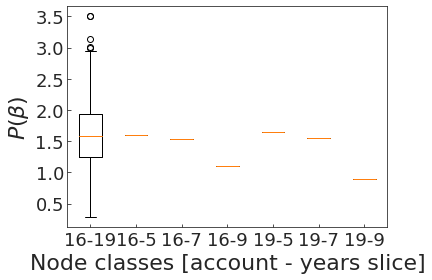

In [21]:
# Betas overall
groups = [(16,19)]
year_slices = [5, 7, 9]

beta_opt = [ [Beta_int[np.argmin([Chi_Sums[bb_val][class_tup] for bb_val in Beta_int])]\
                      for class_tup in Pn_Curves.keys()] ]
beta_pop = [ [DATA["Bins"]["N_A_K"][class_tup] for class_tup in Pn_Curves.keys()] ]
chi2_opt = [[Chi_Sums[Beta_int[np.argmin([Chi_Sums[bb_val][class_tup] for bb_val in Beta_int])]][class_tup]
                      for class_tup in Pn_Curves.keys()
            ]]

groups.extend([(kind, year_slice) for kind in groups[0] for year_slice in year_slices])
beta_opt.extend([ [Beta_int[np.argmin([Chi_Sums[bb_val][class_tup] for bb_val in Beta_int])]\
                      for class_tup in Pn_Curves.keys() if class_tup[:2] == tmp_kind]\
            for tmp_kind in groups[1:]])

beta_pop.extend([ [DATA["Bins"]["N_A_K"][class_tup]\
                    for class_tup in Pn_Curves.keys() if class_tup[:2] == tmp_kind]\
                    for tmp_kind in groups[1:]])


plt.boxplot(beta_opt, labels=["-".join(["%s" % g for g in group]) for group in groups]);
#plt.legend();

plt.xticks(size=18)
plt.yticks(size=18)

plt.xlabel("Node classes [account - years slice]", size = 22);
plt.ylabel(r"$P(\beta)$", size = 22);

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/%s_BetaBoxPlot.pdf" % binningScheme),
    bbox_inces="tight")

In [22]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = numpy.average(values, weights=weights)
    # Fast and numerically precise:
    variance = numpy.average((values-average)**2, weights=weights**2)
    return (average, math.sqrt(variance))

betas_opt_arr = np.array(beta_opt[0])
chi2_opt_array = np.array(chi2_opt[0])**2.
pop_opt_array = np.array(beta_pop[0])

print np.mean(betas_opt_arr), np.std(betas_opt_arr)
res_wgt = weighted_avg_and_std(betas_opt_arr, chi2_opt_array)
print res_wgt, res_wgt[1]**2.
res_wgt = weighted_avg_and_std(betas_opt_arr, pop_opt_array)
print res_wgt, res_wgt[1]**2.

1.6274141876430208 0.5043299427446533
(1.6386107224694233, 0.18051597252063126) 0.0325860163351
(1.9291060659381423, 0.3497737314179319) 0.12234166319


In [23]:
# See delta beta as widht of chi2 curve

bottomRatio = 1.1
minChi2Ind = np.argmin(Tot_Chi_Sums)
minChi2Val = Tot_Chi_Sums[minChi2Ind]
print Beta_int[np.argmax(Tot_Chi_Sums < minChi2Val*bottomRatio)],\
      Beta_int[minChi2Ind],\
      Beta_int[minChi2Ind + np.argmax(Tot_Chi_Sums[minChi2Ind:] > minChi2Val*bottomRatio)],\

1.57 1.7 1.86


In [24]:
# Computing the beta distribution...
beta_opt = [ [Beta_int[np.argmin([Chi_Sums[bb_val][class_tup] for bb_val in Beta_int])]\
                      for class_tup in Pn_Curves.keys()] ]


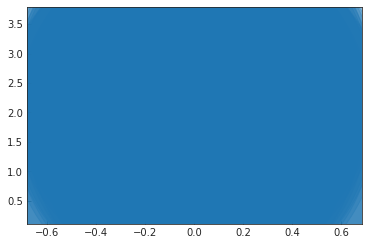

In [25]:
for i, (pop, val, label) in enumerate(zip(beta_pop, beta_opt, groups)):
    plt.scatter(np.ones(len(pop))*i, val, s=np.array(pop)/1., alpha=.3, label=label)
#plt.legend()

# ... now the $P(a,k,t)$...

    - Choose the activity classes to plot;
    - choose the time of reference;
    - choose the scaling picture expected (if no parameters are found);
    - select the times to be plotted as well...

In [26]:
# Select the aggregator of classes...
currentSuperClass = lambda classID: classID[:1]
selectedSuperClasses = [(3,), (4,), (5,), (7,), (9,), (12,), (16,), (25,), (22,), (29,)]
selectedSuperClasses = [(i,) for i in range(0, max(k[0] for k in DATA["pkt"].keys()), 1)]

Scaling_scheme = "StrBR"    # 'SupBR' for alpha > (2beta+2)/(2beta+1) (poissonian scheme),
                            # 'WBR' for weak burstiness regime, and
                            # 'StrBR' for alpha < 1.0;

Times = range(0, DATA["Params"]["timeSampled"])     # The indexes of the TVec to be considered...

#########################################
# Selecting the reference time...
ref_time = DATA['TimeVecs']['TVec']

In [27]:
# Select the aggregator of classes...
currentSuperClass = lambda classID: classID[:1]
selectedSuperClasses = [(3,), (4,), (5,), (7,), (9,), (12,), (16,), (25,), (22,), (29,)]
selectedSuperClasses = [(i,) for i in range(0, max(k[0] for k in DATA["pkt"].keys()), 1)]


Scaling_scheme = "StrBR"    # 'SupBR' for alpha > (2beta+2)/(2beta+1) (poissonian scheme),
                            # 'WBR' for weak burstiness regime, and
                            # 'StrBR' for alpha < 1.0;

Times = range(5, DATA["Params"]["timeSampled"])     # The indexes of the TVec to be considered...

smoothFactor = 1.5

#########################################
# Selecting the reference time...
ref_time = DATA['TimeVecs']['TVec']

In [28]:
from scipy.optimize import curve_fit

In [29]:
from scipy.optimize import curve_fit

def expDecrease(x, a, b):
    return a*np.exp(-x/b)

In [30]:
Pakt = DATA['pkt']
for superClass in sorted(selectedSuperClasses):
    somePlot = False
    degsFreqs = {}
    validKeys = [nodeClass for nodeClass in Pakt.keys() if currentSuperClass(nodeClass) == superClass]
    #print validKeys
    for nodeClass in validKeys:
        Res = Pakt[nodeClass]
        for time, Values in Res.iteritems():
            if time not in Times:
                continue
            for tmpDeg, tmpFreq in Values.iteritems():
                degsFreqs.setdefault(time, {})
                degsFreqs[time].setdefault(tmpDeg, 0)
                degsFreqs[time][tmpDeg] += tmpFreq
    if len(degsFreqs) < 2:
        continue
        
    k_min, k_max, y_min, y_max = 1000000, -1000000, 1000000, -1000000
        
    max_time = max(degsFreqs.keys())
    for time, pkt in sorted(degsFreqs.items()):
        ks = np.array([k for k, f in sorted(pkt.items())], dtype=float)
        ns = np.array([f for k, f in sorted(pkt.items())], dtype=int)
        
        if len(ks) < 5:
            continue

        avg_k = (ks*ns).sum()/ns.sum()

        if Scaling_scheme == "SupBR":
            bins = np.linspace(ks[0], ks[-1], max(50,min(int(ks.max()/ks.min()), 30)))
            bins = np.arange(ks[0]-.5, ks[-1]+.5, 1)
        else:
            bins = Lin_Log_Bins(max(1., ks[0]), max(2., ks[-1]), factor=1.25)
            bins = np.arange(ks[0]-.5, ks[-1]+.5, 1)

        freq, bins = np.histogram(ks, weights=ns, bins=bins, density=True)
        ks = bins[1:]+bins[:-1]
        ks /= 2.
        ks = ks[freq > .0]
        freq = freq[freq > .0]
        X = ks
        Y = freq
        
        if len(X) < 3:
            #print "pochik", bins
            continue
        somePlot = True
        
        if Scaling_scheme == "SupBR":
            X -= avg_k
            X /= np.sqrt(avg_k)
            Y *= np.sqrt(avg_k)
            X_plot, Y_plot = Smooth_Curve(X, Y, binning="lin", factor=1.)
            if max(Y_plot) > .0:
                if time == max_time:
                    plt.semilogy(X_plot,Y_plot, lw=4)#,label="%.02e"%ref_time[time])
                else:
                    plt.semilogy(X_plot,Y_plot, lw=2, alpha=.8, linestyle='--')#,label="%.02e"%ref_time[time])
        else:
            X /= np.sqrt(avg_k)
            Y *= np.sqrt(avg_k)
            if time == max_time:
                plt.semilogy(X, Y, lw=4)#,label="%.02e"%ref_time[time])
            else:
                plt.semilogy(X, Y, lw=2, alpha=.8, linestyle='--')#,label="%.02e"%ref_time[time])
            
        k_min, k_max = min(k_min, X.min()), max(k_max, X.max())
        y_min, y_max = min(y_min, Y.min()), max(y_max, Y.max())

    if somePlot:
        if False:
            peak = ks[ns.argmax()]
            max_k = peak*3.
            ns = ns[ks < max_k]
            ks = ks[ks < max_k]
        Distrib_tmp = Gaussian_PDF((X*Y).mean(), (X*Y).std())
        X_tmp = np.linspace(k_min*.8, k_max*1.2, 100)
        Y_tmp = Gaussian_PDF.pdf(X_tmp)
        Y_tmp *= Y.max()/Y_tmp.max()
        #plt.plot(X_tmp, Y_tmp, '--k', lw=2, alpha=.8)

        plt.xticks(size=16)
        plt.yticks(size=16)
        plt.xlabel(r"$\tilde k = \frac{k^{1+\beta}}{(1+\beta)t^\alpha}$", size=22)
        plt.ylabel(r"$\frac{\tilde k}{1+\beta}P(a,k,t)$", size=22)

        Alpha = .5

        if Alpha <= 1.:
            plt.xlabel(r"$k/\sqrt{\langle k \rangle}$", size=22)
            plt.ylabel(r"$\sqrt{\langle k \rangle} P(k,t)$", size=22)
        elif (1<Alpha<= 2.) and (not Gaussian):
            plt.xlabel(r"$(k-\langle k(t)\rangle)/t^{\frac{1}{\alpha}-\frac{1}{(1+\beta)}}$", size=22)
            plt.ylabel(r"$t^{\frac{1}{\alpha}-\frac{1}{(1+\beta)}} P(k,t)$", size=22)
        else:
            plt.xlabel(r"$(k-\langle k(t)\rangle)/(t^{1/(2(1+\beta))})$", size=22)
            plt.ylabel(r"$t^{1/(2(1+\beta))} P(k,t)$", size=22)

        #plt.xlim(k_min-.5, np.abs(k_min)*89.2)
        #plt.ylim(max(5e-5, y_min*.8), y_max*1.2)

        XMIN, XMAX = k_min-1.5, np.abs(k_min)*100.2
        
        IFIT = np.logical_and(X>X[min(Y.argmax() + 10, len(X)-2)], X <= XMAX)
        XFIT, YFIT = X[IFIT], Y[IFIT]
        #print len(XFIT)
        if len(XFIT) > 3:
            res = curve_fit(expDecrease, XFIT, YFIT, sigma=1./YFIT**3.,
                    p0=[1., 5.], bounds=((1e-8, 1e-1), (1e8, 1e3)))

            XT = X[X<=XMAX*1.2]
            YT = expDecrease(XT, *res[0])
            #YT = np.exp(-XT/7.5)
            #print Y[-10:], YT[-10:]
            plt.plot(XT, YT, "-k", alpha=.8, lw=3,
                     label=r"$\exp{(-k/%d)}$" % res[0][1])
        
        plt.ylim(max(1e-4, y_min*.8), y_max*1.2)
        plt.xlim(XMIN, min(X.max(), XMAX))
                
        if False:
            plt.xscale("log")
            plt.xlim(1e-2, k_max)
        
        plt.legend(loc=1, fontsize=14, ncol=1)
        
        plt.tight_layout()
        plt.savefig(os.path.join(BASE_DIR, "P_akt/%s_Pakt_%s.pdf" %
            (binningScheme, "-".join("%d"%c for c in superClass))),\
            bbox_inches='tight')
        plt.close()

In [31]:
print("aaaaaaaaaaaaa")

aaaaaaaaaaaaa


## The $\langle k(a,t)\rangle_a$...

In [69]:
# Select the aggregator of classes...
tmpBins = DATA["Bins"]["Bins"]

if False:
    nodeSplitting = "ea"
    currentSuperClass = lambda classID: classID[:2]
    selectedSuperClasses = [(i,j,) for i in range(6, len(tmpBins["b"]), 2) for j in range(4, len(tmpBins["v"][i]["b"]), 4)]
else:
    nodeSplitting = "e"
    currentSuperClass = lambda classID: classID[:1]
    selectedSuperClasses = [(i,) for i in range(3, len(tmpBins["b"])-5, 1)]
    
activityString = "a" if binningScheme in ("ak") else "e"

# Fitting classes to account...
classFrom, classTo = 0, len(selectedSuperClasses)
fit_from = 4e6

# plotting the fit from to, moving it by...
fit_plot_interval, fit_offset = np.logspace(6.195, 10.5), .75

# x axis limit (set to None for free plot)
xlim = (2e1, 6e4)
ylim = (3e-1, 5e1)

In [70]:
def avgAct(DATA, nodeClass, activityStr="a"):
    tmpBin = DATA["Bins"]["Bins"]
    binningScheme = DATA["Params"]["binningScheme"]
    i = -1
    for i in range(binningScheme.index(activityStr)):
        tmpBin = tmpBin["v"][nodeClass[i]]
    return sum(tmpBin["b"][nodeClass[i+1]:nodeClass[i+1]+1])/2.

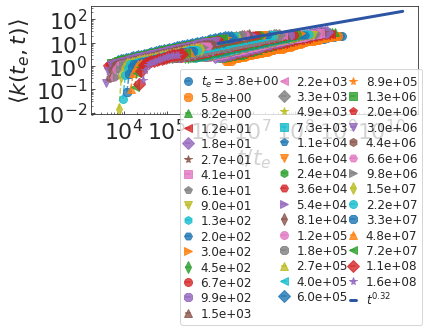

In [71]:
kat = DATA['pkt']

acts = np.array(DATA['Arrays']['Act'])
max_act = acts.max()
acts /= max_act
avg_act = acts.sum()/len(acts)
plt.figure(figsize=(6,4))

Fit_X, Fit_Y = [], []
firstPlot = True
for superClass in sorted(selectedSuperClasses):
    # kat[act_class]
    degsFreqs = {}
    validKeys = [nodeClass for nodeClass in Pakt.keys() if currentSuperClass(nodeClass) == superClass]
    #print validKeys
    for nodeClass in validKeys:
        Res = Pakt[nodeClass]
        for time, Values in Res.iteritems():
            if time not in Times:
                continue
            for tmpDeg, tmpFreq in Values.iteritems():
                degsFreqs.setdefault(time, {"k": .0, "n": .0})
                degsFreqs[time]["k"] += tmpDeg*tmpFreq
                degsFreqs[time]["n"] += tmpFreq
                
    # Define something similar to mindeg to compute the avg act...
    act_tmp = avgAct(DATA, nodeClass, activityStr=activityString)
    
    X = np.array([float(DATA["TimeVecs"]["EventsT"][k]) for k, v in sorted(degsFreqs.items())])
    
    #Y = np.array([v["k"]/v["n"] for k, v in sorted(degsFreqs.items())])
    Y = np.array([v["k"]/degsFreqs[max(degsFreqs.keys())]["n"] for k, v in sorted(degsFreqs.items())])

    
    if activityString == "a":
        ####### X *= act_tmp + avg_act
        X *= act_tmp/max_act + avg_act
    elif activityString == "e":
        #X /= act_tmp**.85
        X /= act_tmp**.5
    
    plt.loglog(X, Y, '--', label=r"$t_e=$"*firstPlot + "%.01e"%act_tmp,
               marker=markers[selectedSuperClasses.index(superClass)%len(markers)],\
               ms=8, alpha=.8, lw=1.5)#, label="%02d"%act_class)
    if firstPlot: firstPlot = False
    
    if superClass in selectedSuperClasses[classFrom:classTo]:
        if len(X[X>=fit_from]) > 5:
            Fit_X.append(X[X>=fit_from])
            Fit_Y.append(Y[X>=fit_from])

pars_out = []
chi2_out = []
for curveX, curveY in zip(Fit_X, Fit_Y):
    if len(curveX) < 5: continue
    par_out, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(Power_Growth, x0=[1., .5, 1e-6],
        args=(curveX, curveY), bounds=[(1e-8, 1e+8), (0.025, 1.025), (.0, 1e-4)],
        approx_grad=True, maxfun=1000000, maxiter=1000000)
    pars_out.append(par_out)
    chi2_out.append(chi2_tmp)
    
bestExp = np.average([p[1] for p in pars_out],
                      weights=[1./max(1e-3, c) for c in chi2_out])
bestPars = (pars_out[-1][0], bestExp, pars_out[-1][2])
par_out_emp, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(Power_Growth,
        x0=bestPars, args=(Fit_X[-1], Fit_Y[-1], 1./Fit_X[-1]), bounds=[(1e-8, 1e+8),
                                                          (bestExp*.9999, bestExp*1.0001),
                                                          (.0, 1e-4)],
        approx_grad=True, maxfun=1000000, maxiter=1000000)

bestBeta = (1./bestExp - 1.)
plt.loglog(fit_plot_interval, fit_offset*Power_Growth(par_out_emp, fit_plot_interval), '-',
           label=r"$t^{%.02f}$"%bestExp, color="#2c55a3", lw=3)

par_out_theor, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(Power_Growth, x0=[1., 1./(1.+Beta_Opt), 1e-6],\
        args=(Fit_X[-1], Fit_Y[-1], 1./Fit_X[-1]), bounds=[(1e-8, 1e+8), (1./(1.+Beta_Opt)*.9999, 1./(1.+Beta_Opt)*1.0001), (.0, 1e-4)],\
        approx_grad=True, maxfun=1000000, maxiter=1000000)
#plt.loglog(fit_plot_interval, .75*fit_offset*Power_Growth(par_out_theor, fit_plot_interval), '--',\
#           label=r"$\beta_{\rm opt}=%.02f$"%Beta_Opt, color="#2c55a3", lw=2.5)

plt.xticks(size=22)
plt.yticks(size=22)

if False:#binningScheme in ["ak", "eak"]:
    plt.xlabel(r"$t \left(\langle a\rangle + a\right)$", size=22)
    plt.ylabel(r"$\langle k(a,t)\rangle$", size=22)
else:#if binningScheme in ["ek"]:
    plt.xlabel(r"$t / t_e$", size=22)
    plt.ylabel(r"$\langle k(t_e,t)\rangle$", size=22)

if False:
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

plt.legend(loc="upper left", fontsize=12, ncol=3,
           handlelength=.5, bbox_to_anchor=(.255,.475), labelspacing=.2,
          columnspacing=.2)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "kat/%s_kat_eve.pdf"
                         % (binningScheme)), bbox_inches='tight')

In [72]:
Beta_Opt, activityString, bestExp, bestBeta

(1.915, 'e', 0.3194777632906459, 2.1301083045653066)

0.366397659388344 0.042804716635986055


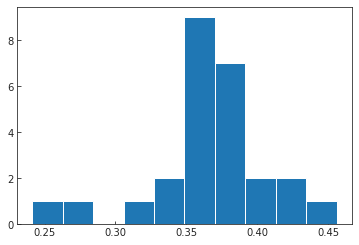

In [73]:
res_exps = np.array([p[1] for p in pars_out])
plt.hist(res_exps)

print np.mean(res_exps), np.std(res_exps)

## The time-depending observables

In [37]:
from scipy.optimize import curve_fit

In [38]:
timeEvents = np.array(DATA["TimeVecs"]["EventsT"])

In [39]:
## Set once and for all the vector of dates linked with the number of events (i.e., the positions in the TVec vector)
timeDates = []
useDates = False

if useDates:
    import datetime
    eventsCounter = 0
    for fname in sorted(os.listdir(dataDir)):
        if fname.startswith("."):
            continue
        with open(os.path.join(dataDir, fname)) as tmp_file:
            for line in tmp_file:
                vals = line.strip().split()
                if vals[0] == vals[1]:
                    continue

                eventsCounter += 1
                if eventsCounter >= DATA["TimeVecs"]["EventsT"][len(timeDates)]:
                    tmp_date = "_".join(fname.split("_")[-2:])
                    timeDates.append(datetime.datetime.strptime(tmp_date, "%Y_%m.dat"))
    timeDates = np.array(timeDates)
else:
    timeDates = timeEvents
print len(timeEvents) == len(timeDates)

True


In [40]:
selectedTime = timeEvents # timeEvents or timeDates

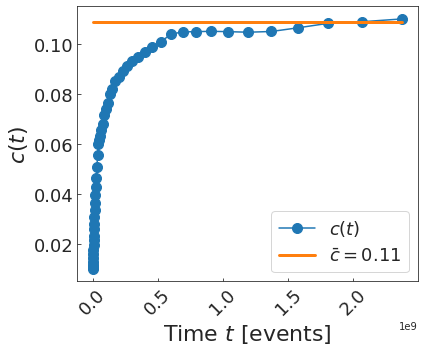

In [41]:
def asymptoticLevel(x, y0):
    return np.ones(len(x))*y0

plt.figure(figsize=(6,5))

XXXs, YYYs = timeEvents, DATA["TimeVecs"]["Clust_t"]
SSSs = 1./(XXXs + 1.)**2.
plt.plot(XXXs, YYYs, "o-", label=r"$c(t)$", ms=10)

p_res, c_res = curve_fit(asymptoticLevel, XXXs, YYYs, sigma=SSSs, p0=(.5), bounds=(1e-5, 1.))
plt.plot(XXXs, asymptoticLevel(XXXs, *p_res), '-C1', lw=3, label=r"$\bar c=%.02f$" % p_res[0])

plt.xscale("linear")
plt.xticks(size=18, rotation=45)
plt.yticks(size=18)
plt.xlabel(r"Time $t$ [events]", size=22)
plt.ylabel(r"$c(t)$", size=22)
plt.legend(loc="best", fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "kat/clustering_t.pdf"), bbox_inces="tight")

In [63]:
# Asymptotic fluctuations
clustAsymptStart = 2e9

XXXs, YYYs = np.array(timeEvents), np.array(DATA["TimeVecs"]["Clust_t"])
SSSs = 1./(XXXs + 1.)

YYYs = YYYs[XXXs >= clustAsymptStart]
SSSs = SSSs[XXXs >= clustAsymptStart]
XXXs = XXXs[XXXs >= clustAsymptStart]

print np.mean(YYYs), np.std(YYYs)

0.10955684611468022 0.0005651355184816201


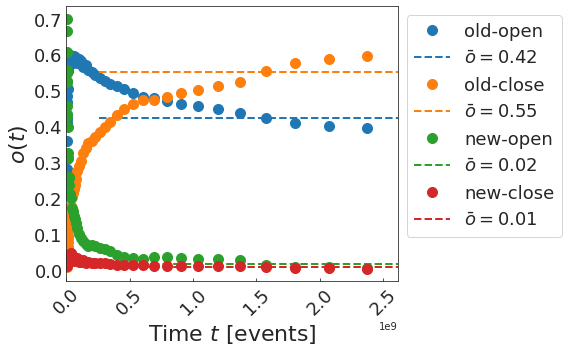

In [78]:
totEve_t = np.array(DATA["TimeVecs"]["newCloseTriang"]) + np.array(DATA["TimeVecs"]["newOpenTriang"])+\
          np.array(DATA["TimeVecs"]["oldOpenTriang"]) +  np.array(DATA["TimeVecs"]["oldCloseTriang"])
selectedTime = timeEvents

plt.figure(figsize=(8,5))
colorIDX = 0
for what, label in zip(
            ["oldOpenTriang", "oldCloseTriang", "newOpenTriang", "newCloseTriang"],
            ["old-open", "old-close", "new-open", "new-close"]
        ):
    XXXs, YYYs = selectedTime, np.array(DATA["TimeVecs"][what],dtype=float)/totEve_t
    SSSs = 1./(XXXs + 1.)
    plt.plot(XXXs, YYYs, "oC%d" % colorIDX, label=label, ms=10)
    p_res, c_res = curve_fit(asymptoticLevel, XXXs, YYYs, sigma=SSSs, p0=(.5), bounds=(1e-5, 1.))
    XTheo = XXXs[len(XXXs)*3/5:]*1.5
    plt.plot(XTheo, asymptoticLevel(XTheo, *p_res), '--C%d' % colorIDX, lw=2,
             label=r"$\bar o = %.02f$" % p_res[0])      
    colorIDX += 1
             
plt.xscale("linear")
plt.xlim(-10, XXXs[-1]*1.1)
plt.xticks(size=18, rotation=45)
plt.yticks(size=18)
plt.xlabel(r"Time $t$ [events]", size=22)
plt.ylabel(r"$o(t)$", size=22)
plt.legend(loc="upper left", fontsize=18, bbox_to_anchor=(1,1))

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "kat/oldNew_openClose_triangles.pdf"), bbox_inces="tight")

In [77]:
# Asymptotic fluctuations
clustAsymptStart = 2e9

selectedTime = np.array(timeEvents)
for what, label in zip(
            ["oldOpenTriang", "oldCloseTriang", "newOpenTriang", "newCloseTriang"],
            ["old-open", "old-close", "new-open", "new-close"]
        ):
    
    XXXs, YYYs = selectedTime, np.array(DATA["TimeVecs"][what],dtype=float)/totEve_t
    SSSs = 1./(XXXs + 1.)

    YYYs = YYYs[XXXs >= clustAsymptStart]
    SSSs = SSSs[XXXs >= clustAsymptStart]
    XXXs = XXXs[XXXs >= clustAsymptStart]

    print label, np.mean(YYYs), np.std(YYYs)

old-open 0.39833027372784335 0.002623347637310286
old-close 0.5917258949674913 0.0035798438132170762
new-open 0.006525235627065773 0.0005556175743460135
new-close 0.0034185956775996023 0.0004008786015607484


In [45]:
XXXs = timeDates
YYYs = DATA["TimeVecs"]["EdgesActiveT"]
SSSs = 1./XXXs**.25

gamma_out, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(
    Power_Growth, x0=[1., .5, 1e-6],
    args=(XXXs, YYYs, SSSs), bounds=[(1e-8, 1e+8), (.1, 1.1), (.0, 1e2)],\
        approx_grad=True, maxfun=1000000, maxiter=1000000)

def Power_Growth_foo(x, A, B, C):
    return A + B * x**C

res_De, chi_De = curve_fit(Power_Growth_foo, XXXs, YYYs, sigma=SSSs,
                           p0=(1e-4, 1e3, 1.), bounds=(1e-4, 1e6))

print res_De, np.sqrt(np.diag(chi_De))

[1.00002037e-04 5.22050936e+03 4.60518365e-01] [2.16622807e+06 2.40237880e+03 2.07038334e-02]


In [46]:
XXXs = timeDates
YYYs = DATA["TimeVecs"]["NodesActiveT"]
SSSs = 1./XXXs**.75

gamma_out, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(
    Power_Growth, x0=[1., .5, 1e-6],
    args=(XXXs, YYYs, SSSs), bounds=[(1e-8, 1e+8), (.1, 1.1), (.0, 1e2)],\
        approx_grad=True, maxfun=1000000, maxiter=1000000)

def Power_Growth_foo(x, A, B, C):
    return A + B * x**C

res_Ne, chi_Ne = curve_fit(Power_Growth_foo, XXXs, YYYs, sigma=SSSs,
                           p0=(1e-4, 1e3, 1.), bounds=(1e-4, 1e6))

print res_Ne, np.sqrt(np.diag(chi_Ne))

[4.28777461e+00 3.95776380e+05 2.07909904e-01] [5.80698167e+06 4.72931071e+05 4.82285015e-02]


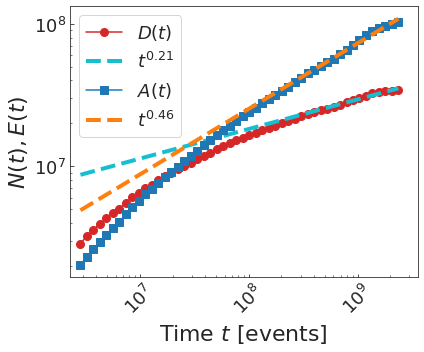

In [47]:
plt.figure(figsize=(6,5))
plt.plot(timeDates, DATA["TimeVecs"]["NodesActiveT"], "o-C3",
         ms=8, label=r"$D(t)$")
plt.plot(XXXs, Power_Growth_foo(XXXs, *res_Ne), "--C9", lw=4,
         label=r"$t^{%.02f}$" % res_Ne[2])

YYYs = DATA["TimeVecs"]["EdgesActiveT"]
plt.plot(timeDates, YYYs, "sC0-", label=r"$A(t)$",
        ms=8)
plt.plot(XXXs, Power_Growth_foo(XXXs, *res_De), "--C1", lw=4,
         label=r"$t^{%.02f}$" % res_De[2])


plt.xscale("log")
plt.yscale("log")
plt.xlim(XXXs[0]*.8, XXXs[-1]*1.5)
plt.xticks(size=18, rotation=45)
plt.yticks(size=18)
plt.xlabel(r"Time $t$ [events]", size=22)
plt.ylabel(r"$N(t), E(t)$", size=22)
plt.legend(loc=2, fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "kat/active_nodesEdges.pdf"), bbox_inces="tight")

## Cumulative degree and weights

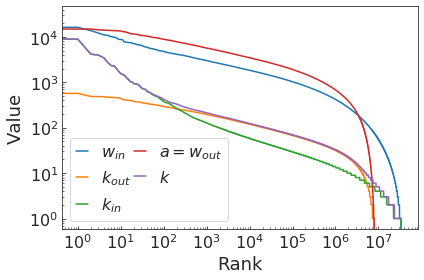

In [48]:
labelDict = {
    "Win":  r"$w_{in}$",
    "Kout": r"$k_{out}$",
    "Kin":  r"$k_{in}$",
    "Act":  r"$a = w_{out}$",
    "Deg":  r"$k$",
}

for what, arra in DATA["Arrays"].iteritems():
    if what in ["IDs", "Entr"]:
        continue
    plt.loglog(np.sort(arra)[::-1], label=labelDict[what])

plt.xlabel("Rank", size=18)
plt.ylabel("Value", size=18)

plt.xticks(size=16)
plt.yticks(size=16)

plt.legend(loc="best", fontsize=16,
           ncol=2, columnspacing=.2, handlelength=.75)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/rank_plot.pdf"), bbox_inces="tight")

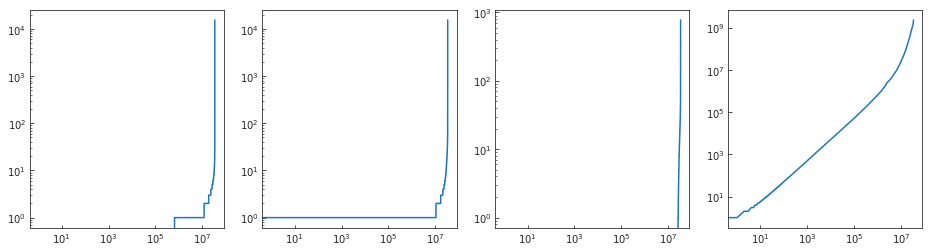

In [49]:
fig = plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.loglog(np.sort(DATA["Arrays"]["Kin"]))
plt.subplot(1,4,2)
plt.loglog(np.sort(DATA["Arrays"]["Deg"]))
plt.subplot(1,4,3)
plt.loglog(np.sort(DATA["Arrays"]["Kout"]))
plt.subplot(1,4,4)
plt.loglog(np.sort(DATA["Arrays"]["Entr"]))

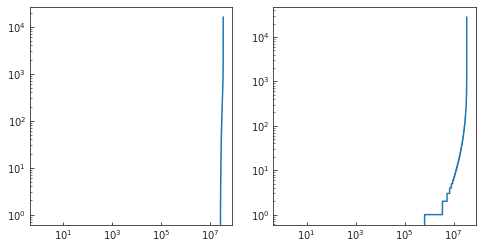

In [50]:
fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.loglog(np.sort(DATA["Arrays"]["Act"]))
plt.subplot(1,2,2)
plt.loglog(np.sort(DATA["Arrays"]["Win"]))

In [51]:
Beta_Opt = 1.97

In [52]:
dat_file_name_urns = "/home/ubi/urns_serie/out/Symm_SonsExchg1_StrctSmpl1_r21_n07_t000050000000_Run_00/data/networkStats_a125_k125_e150_stBySt1_tScheve_bSchek.dat.gz"
DATA_urns = cPickle.load(gzip.open(dat_file_name_urns, 'rb'))

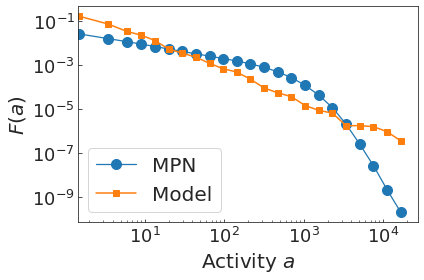

In [53]:
f, b = np.histogram(DATA["Arrays"]["Act"], bins =Lin_Log_Bins(1, 20000, factor=1.5), density=True)
from scipy.optimize import curve_fit

def powLaw(x, const, esponent):
    return const * x**(-esponent)

b = (b[:-1] + b[1:])/2.
b = b[f>0]
f = f[f>0]
plt.loglog(b, f, "o-C0", ms=10, lw=1.25, label="MPN")

f_u, b_u = np.histogram(DATA_urns["Arrays"]["Act"], bins =Lin_Log_Bins(1, 20000, factor=1.5), density=True)
b_u = (b_u[1:]+b_u[:-1])/2.
b_u = b_u[f_u>0]
f_u = f_u[f_u>0]
plt.loglog(b_u, f_u, "s-C1", label="Model")

res_nu, cov_nu = curve_fit(powLaw, b_u, f_u,
                           p0=[1., -1.], sigma=1./b_u**1.5,
                           bounds=((1e-8, -3.1), (1e8, 3.1)))

b_XXX = np.logspace(np.log10(min(min(b), min(b_u)))*.95,
                    np.log10(max(max(b), max(b_u)))*1.05, 20)
#plt.loglog(b_XXX, powLaw(b_XXX, *res_nu), "-C2", lw=2,
#           label=r"$F(a) \propto a^{-%.02f}$" % res_nu[1])

plt.xlim(b_XXX[0], b_XXX[-1])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Activity $a$", size=20)
plt.ylabel(r"$F(a)$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

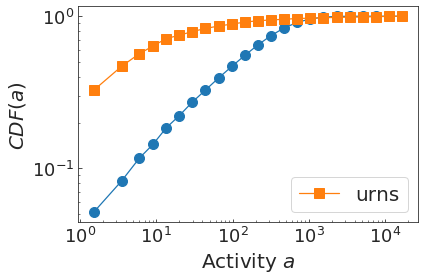

In [54]:
# CDF
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])

aaa_data.sort()
aaa_urns.sort()

#plt.loglog(aaa_data, np.arange(aaa_data.size)/float(aaa_data.size))
#plt.loglog(aaa_urns, np.arange(aaa_urns.size)/float(aaa_urns.size))


f, b = np.histogram(aaa_data, bins =Lin_Log_Bins(1, 20000, factor=1.5), density=True)
deltaB = np.diff(b)
cdf_data = np.cumsum(f*deltaB)
b = (b[:-1] + b[1:])/2.
plt.loglog(b, cdf_data, "o-C0", ms=10, lw=1.25)

f, b = np.histogram(aaa_urns, bins =Lin_Log_Bins(1, 20000, factor=1.5), density=True)
deltaB = np.diff(b)
b = (b[:-1] + b[1:])/2.
cdf_urns = np.cumsum(f*deltaB)
plt.loglog(b, cdf_urns, "s-C1", ms=10, lw=1.25, label="urns")

plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Activity $a$", size=20)
plt.ylabel(r"$CDF(a)$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a_cdf.pdf"), bbox_inces="tight")

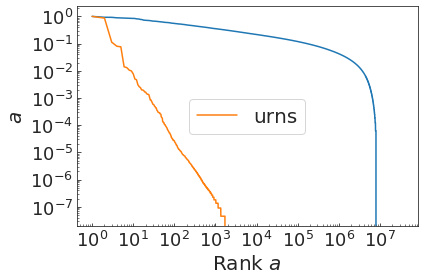

In [55]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])

from scipy.optimize import curve_fit

def powLaw(x, const, esponent):
    return const * x**(-esponent)


plt.loglog(np.arange(1, len(aaa_data)+1), aaa_data[np.argsort(aaa_data)[::-1]]/float(max(aaa_data)))
plt.loglog(np.arange(1, len(aaa_urns)+1), aaa_urns[np.argsort(aaa_urns)[::-1]]/float(max(aaa_urns)), label="urns")
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Activity $a$", size=20)
plt.ylabel(r"$F(a)$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
#plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Rank $a$", size=20)
plt.ylabel(r"$a$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a_freqRank.pdf"), bbox_inces="tight")

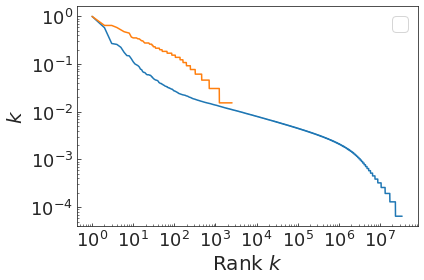

In [56]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])

from scipy.optimize import curve_fit

def powLaw(x, const, esponent):
    return const * x**(-esponent)


plt.loglog(np.arange(1, len(kkk_data)+1), kkk_data[np.argsort(kkk_data)[::-1]]/max(kkk_data))
plt.loglog(np.arange(1, len(kkk_urns)+1), kkk_urns[np.argsort(kkk_urns)[::-1]]/max(kkk_urns))
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Degree $k$", size=20)
plt.ylabel(r"$F(k)$", size=20)
plt.legend(loc=1, fontsize=20)

plt.tight_layout()

plt.tight_layout()
#plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Rank $k$", size=20)
plt.ylabel(r"$k$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/F_k_freqRank.pdf"), bbox_inces="tight")
#plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

In [57]:
Beta_Opt = 1.915

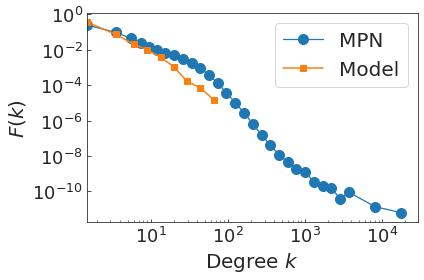

In [58]:
f, b = np.histogram(DATA["Arrays"]["Deg"], bins =Lin_Log_Bins(1, 20000, factor=1.3), density=True)

b = (b[:-1] + b[1:])/2.
b = b[f>0]
f = f[f>0]

f_u, b_u = np.histogram(DATA_urns["Arrays"]["Deg"], bins =Lin_Log_Bins(1, 20000, factor=1.5), density=True)
b_u = (b_u[1:]+b_u[:-1])/2.
b_u = b_u[f_u>0]
f_u = f_u[f_u>0]

sigma_exp = 2.75
offset_const = 1.5
theo_mu = ((1. + Beta_Opt)*res_nu[1] - Beta_Opt)
res_mu, cov_mu = curve_fit(powLaw, b_u, f_u, p0=[1., theo_mu],
        sigma=1./b_u**sigma_exp, bounds=((1e-8, theo_mu*.95), (1e8, theo_mu*1.05)))
res_mu[0] *= offset_const

plt.loglog(b, f, "-oC0", ms=10, lw=1.25, label="MPN")
plt.loglog(b_u, f_u, "s-C1", label="Model")
b_XXX = np.logspace(np.log10(min(min(b), min(b_u)))*.95,
                    np.log10(max(max(b), max(b_u)))*1.05, 20)
#plt.loglog(b_XXX, powLaw(b_XXX, *res_mu), "-C2", lw=2,
#           label=r"$F(k) \propto k^{-%.02f}$" % res_mu[1])

plt.xlim(b_XXX[0], b_XXX[-1])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Degree $k$", size=20)
plt.ylabel(r"$F(k)$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/F_k.pdf"), bbox_inces="tight")

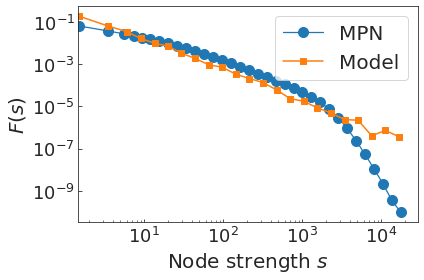

In [59]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])
www_data = np.array(DATA["Arrays"]["Win"]) + np.array(DATA["Arrays"]["Act"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])
www_urns = np.array(DATA_urns["Arrays"]["Win"]) + np.array(DATA_urns["Arrays"]["Act"])


f, b = np.histogram(www_data,
                    bins =Lin_Log_Bins(1, 20000, factor=1.3),
                    density=True)

b = (b[:-1] + b[1:])/2.
b = b[f>0]
f = f[f>0]

f_u, b_u = np.histogram(www_urns,
                        bins =Lin_Log_Bins(1, 20000, factor=1.5),
                        density=True)
b_u = (b_u[1:]+b_u[:-1])/2.
b_u = b_u[f_u>0]
f_u = f_u[f_u>0]

sigma_exp = 2.75
offset_const = 1.5
theo_mu = ((1. + Beta_Opt)*res_nu[1] - Beta_Opt)
res_mu, cov_mu = curve_fit(powLaw, b_u, f_u, p0=[1., theo_mu],
        sigma=1./b_u**sigma_exp, bounds=((1e-8, theo_mu*.95), (1e8, theo_mu*1.05)))
res_mu[0] *= offset_const

plt.loglog(b, f, "-oC0", ms=10, lw=1.25, label="MPN")
plt.loglog(b_u, f_u, "s-C1", label="Model")
b_XXX = np.logspace(np.log10(min(min(b), min(b_u)))*.95,
                    np.log10(max(max(b), max(b_u)))*1.05, 20)
#plt.loglog(b_XXX, powLaw(b_XXX, *res_mu), "-C2", lw=2,
#           label=r"$F(k) \propto k^{-%.02f}$" % res_mu[1])

plt.xlim(b_XXX[0], b_XXX[-1])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Node strength $s$", size=20)
plt.ylabel(r"$F(s)$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/F_s.pdf"),
            bbox_inces="tight")

/usr/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


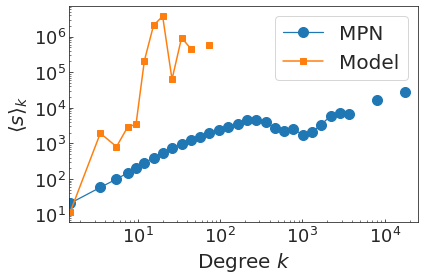

In [60]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])
www_data = np.array(DATA["Arrays"]["Act"]) + np.array(DATA["Arrays"]["Win"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])
www_urns = np.array(DATA_urns["Arrays"]["Act"]) + np.array(DATA_urns["Arrays"]["Win"])

f, b = np.histogram(kkk_data,
                    bins =Lin_Log_Bins(1, 20000, factor=1.3),
                    density=False)

f_u, b_u = np.histogram(www_urns,
                        bins =Lin_Log_Bins(1, 20000, factor=1.3),
                        density=False)

# Now for each bin compute the average strength
avg_www_data = np.array([np.mean(
    www_data[
        np.logical_and(kkk_data>=b[i], kkk_data<b[i+1])
    ])  for i in range(len(b)-1)
])
b = (b[:-1] + b[1:])/2.

avg_www_urns = np.array([np.mean(
    www_urns[
        np.logical_and(kkk_urns>=b_u[i], kkk_urns<b_u[i+1])
    ])  for i in range(len(b_u)-1)
])
b_u = (b_u[:-1] + b_u[1:])/2.


plt.loglog(b, avg_www_data, "-oC0", ms=10, lw=1.25, label="MPN")
plt.loglog(b_u, avg_www_urns, "s-C1", label="Model")
b_XXX = np.logspace(np.log10(min(min(b), min(b_u)))*.95,
                    np.log10(max(max(kkk_data), max(kkk_urns)))*1.05, 20)

plt.xlim(b_XXX[0], b_XXX[-1])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Degree $k$", size=20)
plt.ylabel(r"$\langle s \rangle_k$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/avgWeightVsDegree.pdf"),
            bbox_inces="tight")

In [61]:
DATA["Stats"]

{'CompanyNodes': 34379781,
 'Edges': 102312002.0,
 'Events': 2374842438,
 'Nodes': 34379781}

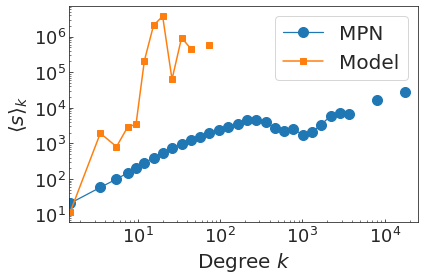

In [62]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])
www_data = np.array(DATA["Arrays"]["Act"]) + np.array(DATA["Arrays"]["Win"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])
www_urns = np.array(DATA_urns["Arrays"]["Act"]) + np.array(DATA_urns["Arrays"]["Win"])

f, b = np.histogram(kkk_data,
                    bins =Lin_Log_Bins(1, 20000, factor=1.3),
                    density=False)

f_u, b_u = np.histogram(www_urns,
                        bins =Lin_Log_Bins(1, 20000, factor=1.3),
                        density=False)

# Now for each bin compute the average strength
avg_www_data = np.array([np.mean(
    www_data[
        np.logical_and(kkk_data>=b[i], kkk_data<b[i+1])
    ])  for i in range(len(b)-1)
])
b = (b[:-1] + b[1:])/2.

avg_www_urns = np.array([np.mean(
    www_urns[
        np.logical_and(kkk_urns>=b_u[i], kkk_urns<b_u[i+1])
    ])  for i in range(len(b_u)-1)
])
b_u = (b_u[:-1] + b_u[1:])/2.


plt.loglog(b, avg_www_data, "-oC0", ms=10, lw=1.25, label="MPN")
plt.loglog(b_u, avg_www_urns, "s-C1", label="Model")
b_XXX = np.logspace(np.log10(min(min(b), min(b_u)))*.95,
                    np.log10(max(max(kkk_data), max(kkk_urns)))*1.05, 20)

plt.xlim(b_XXX[0], b_XXX[-1])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Degree $k$", size=20)
plt.ylabel(r"$\langle s \rangle_k$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/avgWeightVsDegree.pdf"),
            bbox_inces="tight")

In [65]:
from scipy.stats import pearsonr

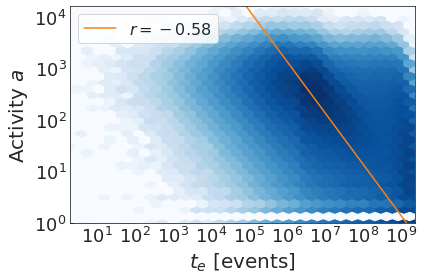

In [66]:
Activity =  np.array(DATA["Arrays"]["Act"])
EntranceFile = np.array(DATA["Arrays"]["Entr"])[Activity>0]
EntranceEvent = np.array(DATA["Arrays"]["Entr"])[Activity>0]
Activity = Activity[Activity>0]
EntranceEvent += 1.

plt.hexbin(EntranceEvent, Activity, bins='log', cmap=plt.cm.Blues, yscale="log", xscale="log", gridsize=30)
#plt.axis([T0s_ev.min(), T0s_ev.max(), Acts.min(), Acts.max()])
pears_e_vs_a = pearsonr(np.log(EntranceEvent), np.log(Activity))


Y_t0_prop_1overA_X = np.logspace(np.log10(EntranceEvent.min()), np.log10(EntranceEvent.max()), 1000)
Y_t0_prop_1overA   = np.logspace(np.log10(EntranceEvent.min()), np.log10(EntranceEvent.max()), 1000)**-1.
Y_t0_prop_1overA /= Y_t0_prop_1overA[-1]
plt.loglog(Y_t0_prop_1overA_X, Y_t0_prop_1overA*np.abs(pears_e_vs_a[0]),
           color="C1", label=r"$r=%.02f$" % pears_e_vs_a[0])

#plt.xscale("log")
#plt.yscale("log")

plt.ylim(Activity.min(), Activity.max())

plt.xlabel(r"$t_e$ [events]", size=20)
plt.ylabel(r"Activity $a$", size=20)

plt.xticks(size=18)
plt.yticks(size=18)


plt.legend(loc="best", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/entr_vs_act.pdf"), bbox_inces="tight")

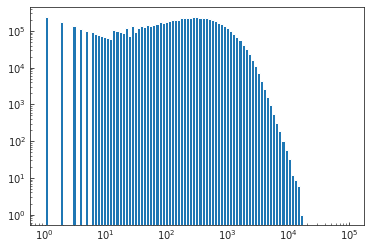

In [67]:
plt.hist(DATA["Arrays"]["Act"], bins=np.logspace(0, 5, 100), density=False)
plt.xscale("log")
plt.yscale("log")

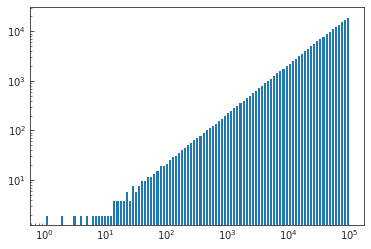

In [68]:
plt.hist(DATA["Arrays"]["Entr"], bins=np.logspace(0, 5, 100), density=False)
plt.xscale("log")
plt.yscale("log")

In [69]:
print "hi"

hi
